# **1. Data Import**

Importing the necessary libraries and data

In [1909]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [1910]:
# Load the data
sales_data = pd.read_csv('data/sales_data.csv')
outlet_data = pd.read_csv('data/outlets_data.csv')
product_data = pd.read_csv('data/product_data.csv')
week_data = pd.read_csv('data/week_data.csv')
freezer_data = pd.read_csv('data/freezer_data.csv')

# **2. Data Preprocesing and Feature Engineering**

Let's try to have a breif look at these data and fix data types

## **Product Data**

In [1911]:
print(product_data.dtypes)
product_data.head()

pid              object
volume          float64
product_name     object
price             int64
dtype: object


,pid,volume,product_name,price
0,IP1,0.2,Vanilla Mini Cone,100
1,IP2,0.2,Chocolate Petite Bar,90
2,IP3,0.2,Strawberry Tiny Cup,110
3,IP4,0.2,Mint Bite-size Pop,100
4,IP5,0.2,Butter Pecan Small Stick,100


In [1912]:
# If pid starts with BP then categorize them as Bulk purchases
product_data['Bulk'] = np.where(product_data['pid'].str.startswith('BP'), 1, 0)
product_data['Impulse'] = np.where(product_data['pid'].str.startswith('IP'), 1, 0)
product_data.head(10)

,pid,volume,product_name,price,Bulk,Impulse
0,IP1,0.2,Vanilla Mini Cone,100,0,1
1,IP2,0.2,Chocolate Petite Bar,90,0,1
2,IP3,0.2,Strawberry Tiny Cup,110,0,1
3,IP4,0.2,Mint Bite-size Pop,100,0,1
4,IP5,0.2,Butter Pecan Small Stick,100,0,1
5,BP1,1.0,Chocolate Fudge Big Scoop,1200,1,0
6,BP2,1.0,Moose Tracks Jumbo Cup,1100,1,0
7,BP3,1.0,Mint Chocolate Chip Family Pack,1150,1,0
8,BP4,1.0,Rocky Road Mega Tub,1000,1,0
9,BP5,1.0,Cookies and Cream Mega Tub,1100,1,0


## **Week Data**

In [1913]:
print(week_data.dtypes)
week_data.head()

Week          object
Start Date    object
End Date      object
dtype: object


,Week,Start Date,End Date
0,Week 1,1/2/2023,1/8/2023
1,Week 2,1/9/2023,1/15/2023
2,Week 3,1/16/2023,1/22/2023
3,Week 4,1/23/2023,1/29/2023
4,Week 5,1/30/2023,2/5/2023


Let's convert Week column into integer data type and make start date and end dates into datetime    

In [1914]:
#remove Week from Week column
week_data['Week'] = week_data['Week'].str.replace('Week ', '')
#convert column into integer
week_data['Week'] = week_data['Week'].astype(int)

#convert start date into date 
week_data['Start Date'] = pd.to_datetime(week_data['Start Date'])

#convert end date into date
week_data['End Date'] = pd.to_datetime(week_data['End Date'])

# #calculate the number of days within the week
# week_data['Days'] = week_data['End Date'] - week_data['Start Date']

print(week_data.dtypes)
week_data.head()

Week                   int64
Start Date    datetime64[ns]
End Date      datetime64[ns]
dtype: object


,Week,Start Date,End Date
0,1,2023-01-02,2023-01-08
1,2,2023-01-09,2023-01-15
2,3,2023-01-16,2023-01-22
3,4,2023-01-23,2023-01-29
4,5,2023-01-30,2023-02-05


## **Sales Data**

In [1915]:
print(sales_data.dtypes)
sales_data.head()

Outlet_ID        object
week              int64
pid              object
product_name     object
no_units        float64
dtype: object


,Outlet_ID,week,pid,product_name,no_units
0,ID7203,1,IP1,Vanilla Mini Cone,874.0
1,ID7203,1,IP2,Chocolate Petite Bar,105.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0
3,ID7203,1,IP4,Mint Bite-size Pop,502.0
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0


## **Outlet Data**

In [1916]:
print(outlet_data.dtypes)
outlet_data.head()

Outlet_ID     object
area(sqft)     int64
dtype: object


,Outlet_ID,area(sqft)
0,ID7203,5660
1,ID1878,4138
2,ID1740,5546
3,ID4366,5134
4,ID8358,4100


In [1917]:
# rename colume area(sqft) into shop_area
outlet_data.rename(columns={'area(sqft)': 'shop_area'}, inplace=True)

Let's enrich the outlets_data with 
1.   Outlet Size
2.   Outlet Space Availability
3.   Outlet Sales
4.   Outlet Location

In [1918]:
# Merge sales data with outlet data, product data, and week data
merged_data = sales_data.merge(outlet_data, on="Outlet_ID").merge(product_data, on="pid").merge(week_data, left_on="week", right_on="Week")
merged_data["total_sales"] = merged_data["no_units"] * merged_data["price"]
merged_data["bulk_sales"] = merged_data["no_units"] * merged_data["price"] * merged_data["Bulk"]
merged_data["impulse_sales"] = merged_data["no_units"] * merged_data["price"] * merged_data["Impulse"]

#calculate the total volume
merged_data["total_volume"] = merged_data["no_units"] * merged_data["volume"]


#remove unnecessary columns
merged_data = merged_data.drop(columns=['week', 'Start Date', 'End Date', 'product_name_y'])

# Calculate the average weekly sales per store
avg_weekly_sales = merged_data.groupby(["Outlet_ID"])["total_sales"].mean().reset_index()
#calculate total sales per store
# total_sales = merged_data.groupby(["Outlet_ID"])["total_sales"].sum().reset_index()
#impulse and bulk sales
total_avg_weekly_impulse_sales = merged_data.groupby(["Outlet_ID"])["impulse_sales"].mean().reset_index()
total_avg_weekly_bulk_sales = merged_data.groupby(["Outlet_ID"])["bulk_sales"].mean().reset_index()

#calculate the average weekly volume per store and total volume per store
avg_weekly_volume = merged_data.groupby(["Outlet_ID"])["total_volume"].mean().reset_index()
# total_volume = merged_data.groupby(["Outlet_ID"])["total_volume"].sum().reset_index()
max_weekly_volume = merged_data.groupby(["Outlet_ID"])["total_volume"].max().reset_index()

# checking the total no of items
total_no_of_items = merged_data.groupby(["Outlet_ID"])["no_units"].sum().reset_index()



#add all these new columns into outlet_data, rename the columns accordingly
# outlet_data = outlet_data.merge(total_sales, on="Outlet_ID")
outlet_data = outlet_data.merge(avg_weekly_sales, on="Outlet_ID")
outlet_data = outlet_data.rename(columns={"total_sales": "avg_sales"})
outlet_data = outlet_data.merge(total_avg_weekly_impulse_sales, on="Outlet_ID")
outlet_data = outlet_data.merge(total_avg_weekly_bulk_sales, on="Outlet_ID")
print(outlet_data["bulk_sales"].nunique())
print(outlet_data["impulse_sales"].nunique())


# outlet_data = outlet_data.merge(total_volume, on="Outlet_ID")
outlet_data = outlet_data.merge(avg_weekly_volume, on="Outlet_ID")
outlet_data = outlet_data.merge(max_weekly_volume, on="Outlet_ID")

outlet_data = outlet_data.rename(columns={"total_volume_x": "avg_volume","total_volume_y": "max_weekly_volume"})

outlet_data = outlet_data.merge(total_no_of_items, on="Outlet_ID")

#create a copy of outlet data
outlet_data_copy = outlet_data.copy()

outlet_data.head()

717
723


,Outlet_ID,shop_area,avg_sales,impulse_sales,bulk_sales,avg_volume,max_weekly_volume,no_units
0,ID7203,5660,65904.150943,65904.150943,0.0,131.116981,239.6,34746.0
1,ID1878,4138,65569.818182,65569.818182,0.0,131.054545,234.6,36040.0
2,ID1740,5546,67069.821429,67069.821429,0.0,134.239286,234.8,37587.0
3,ID4366,5134,76606.226415,76606.226415,0.0,152.090566,239.8,40304.0
4,ID8358,4100,69976.785714,69976.785714,0.0,140.635714,239.2,39378.0


In [1919]:

# total_volume/shop_area ratio
outlet_data["volume_area_ratio"] = outlet_data["avg_volume"] / outlet_data["shop_area"]

# best item sales ratio
outlet_data["best_item_sales_ratio"] = outlet_data["avg_sales"] / outlet_data["avg_volume"]



outlet_data.describe()

,shop_area,avg_sales,impulse_sales,bulk_sales,avg_volume,max_weekly_volume,no_units,volume_area_ratio,best_item_sales_ratio
count,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.00000,988.000000,988.000000
mean,4288.656883,91280.507659,30903.375578,60377.132081,116.182396,218.374696,37423.33502,0.041680,790.936141
std,2451.617799,37567.022343,21549.414312,46210.892859,38.039422,66.455662,31973.17042,0.058091,212.546836
min,123.000000,32940.847458,0.000000,0.000000,51.000000,91.000000,2601.00000,0.009303,492.348524
25%,2325.750000,57943.394608,20170.391817,29484.818178,76.555254,177.600000,19247.00000,0.021797,705.474453
50%,3958.500000,69903.123038,34983.069865,64834.419192,124.265194,210.600000,32161.00000,0.028836,792.588254
75%,5836.000000,131514.503476,41624.603245,92702.104716,151.944290,296.450000,51059.25000,0.040688,867.528757
max,9950.000000,154229.464286,77617.450980,154229.464286,182.185841,299.800000,218336.00000,0.931857,1122.210492


## **Freezer Data**

In [1920]:
print(freezer_data.dtypes)
freezer_data.head()

Freezer Name                                      object
Model Number                                      object
Volume Capacity (Liters)                           int64
Power and maitainance Cost (LKR) per 100 hours     int64
dtype: object


,Freezer Name,Model Number,Volume Capacity (Liters),Power and maitainance Cost (LKR) per 100 hours
0,ChillMaster,M001,55,2500
1,FreezeZone,M002,75,2800
2,CoolTech,M003,120,3200
3,mini CoolTech,M004,30,1800
4,IceBlast Pro,M005,150,3500


In [1921]:
# rename columns with easy to use column name without whitespaces
freezer_data.rename(columns={'Volume Capacity (Liters)': 'volume_capacity', 
                             'Power and maitainance Cost (LKR) per 100 hours': 'power_cost',
                             "Freezer Name":"freezer_name",
                             "Model Number":"model_number"}, inplace=True)

freezer_data["cost_per_capacity"] = freezer_data["power_cost"]/freezer_data["volume_capacity"]

#sort the freezers by cost_per_capacity
freezer_data = freezer_data.sort_values(by=['cost_per_capacity'])

freezer_data.head(12)



,freezer_name,model_number,volume_capacity,power_cost,cost_per_capacity
9,IceTech,M010,200,4500,22.500000
4,IceBlast Pro,M005,150,3500,23.333333
2,CoolTech,M003,120,3200,26.666667
6,FreezeTech,M007,100,3000,30.000000
8,ChillTech,M009,80,2800,35.000000
1,FreezeZone,M002,75,2800,37.333333
5,IceBlast,M006,65,2700,41.538462
0,ChillMaster,M001,55,2500,45.454545
3,mini CoolTech,M004,30,1800,60.000000
7,FreezeTech 3.0,M008,25,1600,64.000000


# **Segmenting the Outlets**

In [1922]:
outlet_data.head()

,Outlet_ID,shop_area,avg_sales,impulse_sales,bulk_sales,avg_volume,max_weekly_volume,no_units,volume_area_ratio,best_item_sales_ratio
0,ID7203,5660,65904.150943,65904.150943,0.0,131.116981,239.6,34746.0,0.023166,502.636275
1,ID1878,4138,65569.818182,65569.818182,0.0,131.054545,234.6,36040.0,0.031671,500.324639
2,ID1740,5546,67069.821429,67069.821429,0.0,134.239286,234.8,37587.0,0.024205,499.628861
3,ID4366,5134,76606.226415,76606.226415,0.0,152.090566,239.8,40304.0,0.029624,503.688220
4,ID8358,4100,69976.785714,69976.785714,0.0,140.635714,239.2,39378.0,0.034301,497.574788


In [1923]:
import warnings
warnings.filterwarnings("ignore")

# Perform store segmentation
X = outlet_data[[	'avg_sales',	'impulse_sales',	'bulk_sales',	'avg_volume',	'best_item_sales_ratio','no_units']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find the optimal number of clusters
scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    scores.append(silhouette_score(X_scaled, kmeans.labels_))

optimal_k = np.argmax(scores) + 2

print("optimal k",optimal_k)

# Fit the KMeans model with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)
outlet_data['cluster'] = kmeans.labels_

# Calculate metrics and recommend suitable freezer types
def calculate_roi_metrics(cluster_df):
    roi_metrics = []
    for _, row in freezer_data.iterrows():
        cluster_df['estimated_sales_volume'] = (cluster_df['total_volume'] * row['volume_capacity']) / cluster_df['shop_area']
        cluster_df['roi'] = cluster_df['estimated_sales_volume'] / (row['power_cost'] + row['volume_capacity'])
        roi = cluster_df['roi'].mean()
        roi_metrics.append((row['Model Number'], roi))
    
    return sorted(roi_metrics, key=lambda x: x[1], reverse=True)[0]

# recommended_freezers = outlet_data.groupby('cluster').apply(calculate_roi_metrics).reset_index(name='recommended_freezer')
# recommended_freezers = recommended_freezers.merge(freezer_data, left_on='recommended_freezer', right_on='Model Number', how='left')

# Evaluation metrics
inertia = kmeans.inertia_
silhouette = silhouette_score(X_scaled, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans.labels_)

print(outlet_data['cluster'].nunique(),"clusters identified")

print("Inertia:", inertia)
print("Silhouette Coefficient:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)
# print("\nRecommended Freezers:")
# print(recommended_freezers[['cluster', 'Freezer Name', 'Model Number']])



optimal k 9
9 clusters identified
Inertia: 137.1622436782286
Silhouette Coefficient: 0.8077852816389179
Davies-Bouldin Index: 0.5119763914647681
Calinski-Harabasz Index: 5166.536733624164


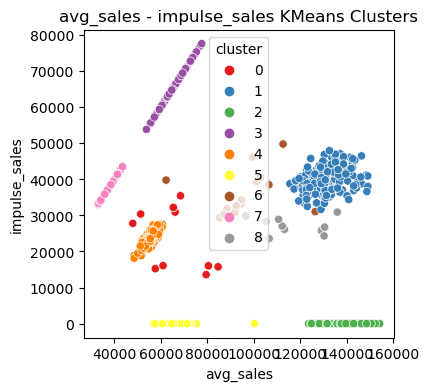

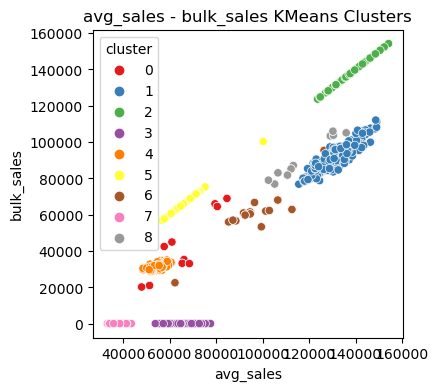

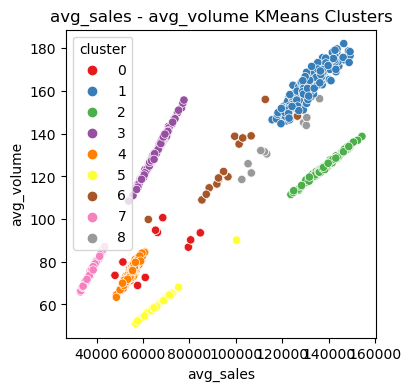

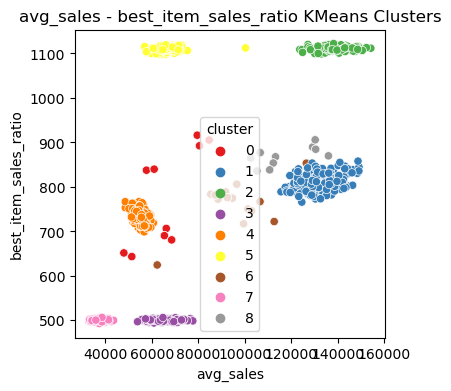

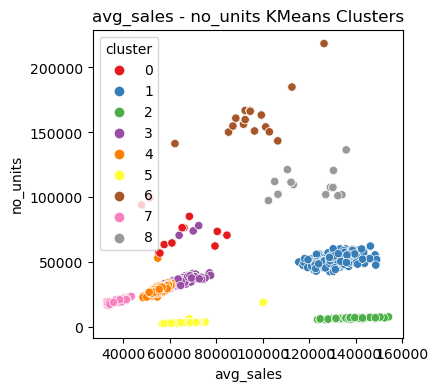

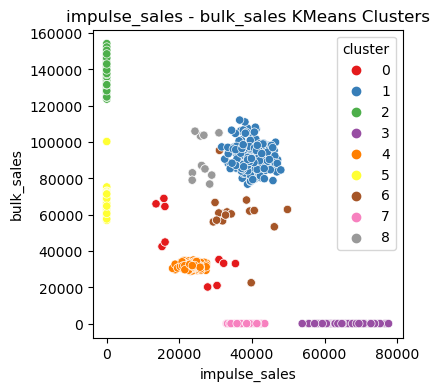

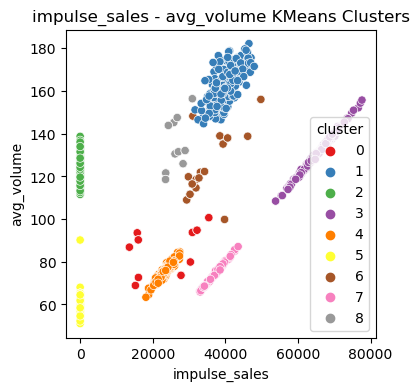

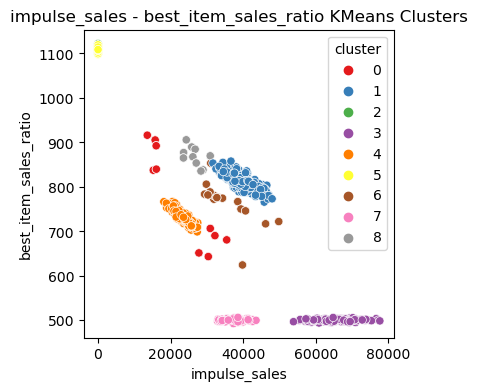

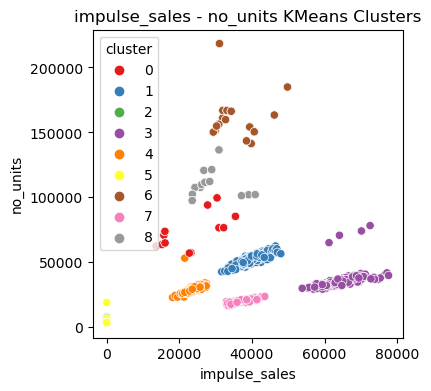

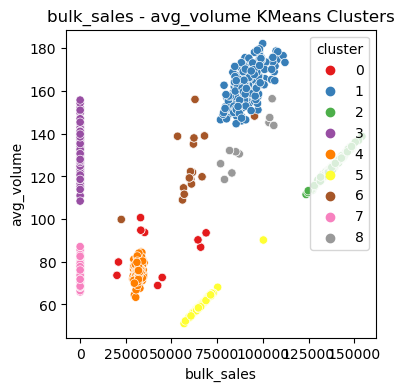

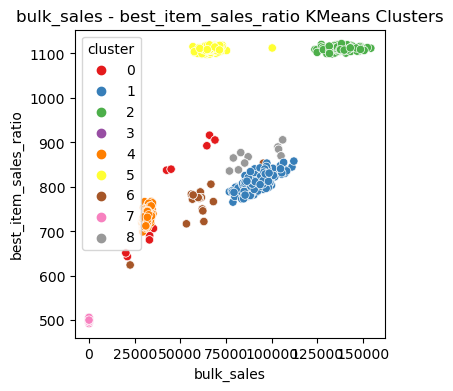

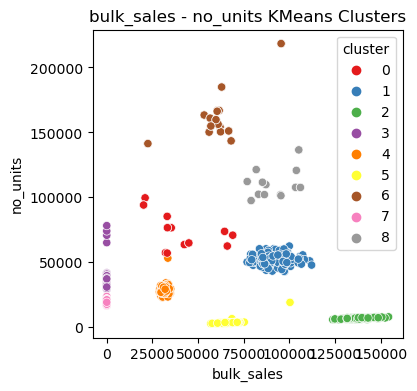

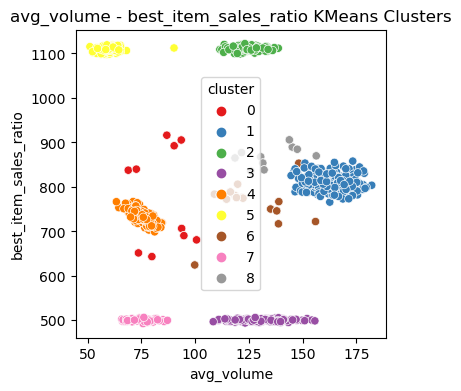

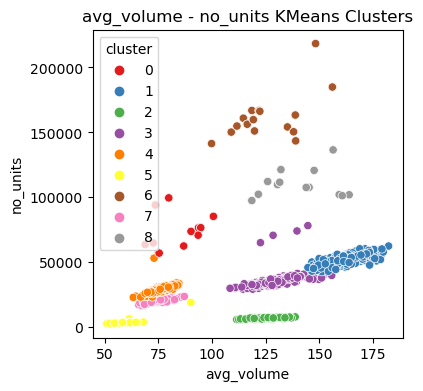

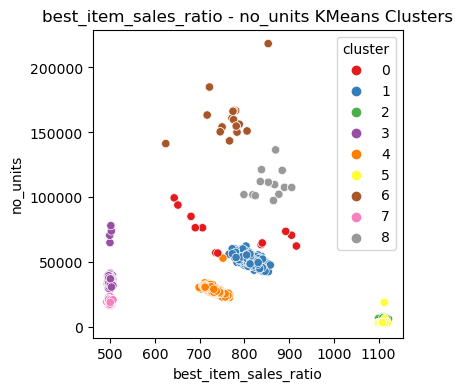

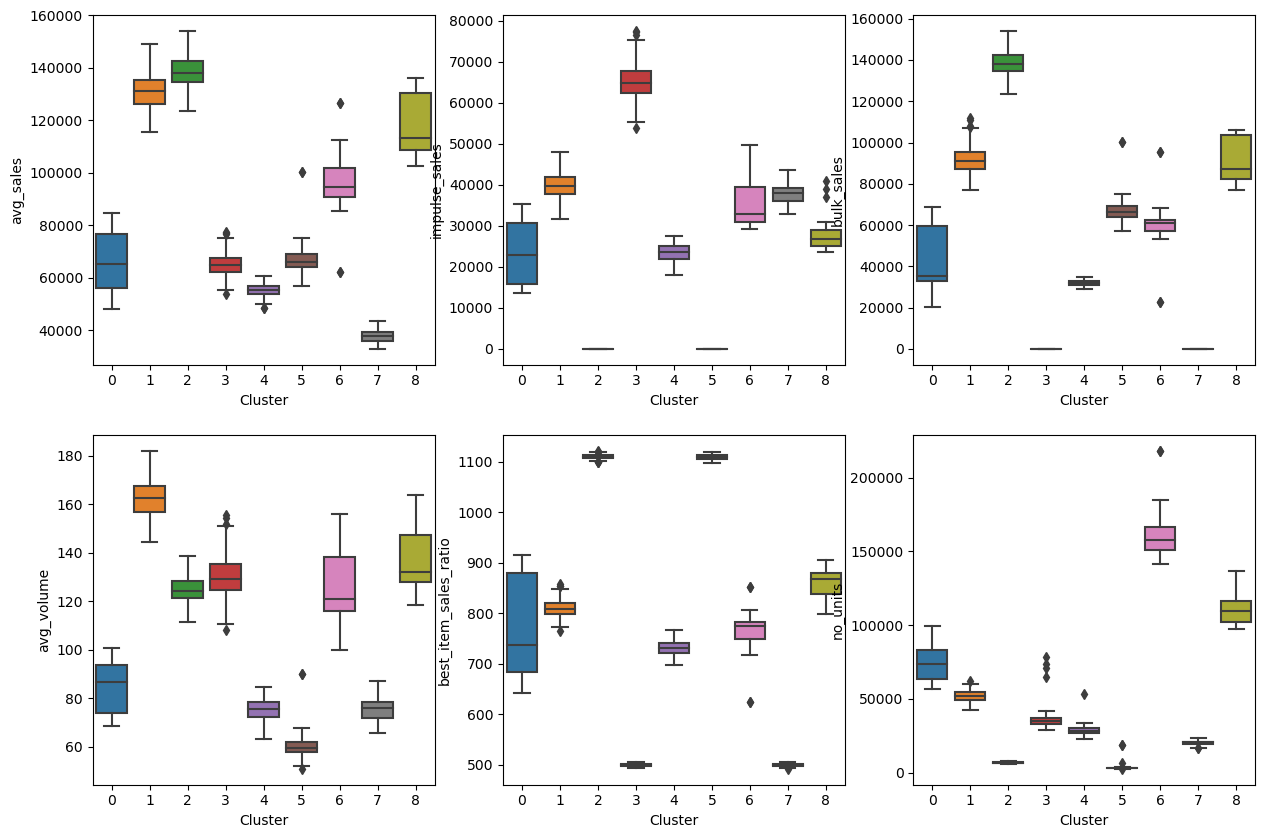

In [1924]:

#count outlets in each cluster
outlet_data.groupby('cluster')['Outlet_ID'].count()

#import plt
import matplotlib.pyplot as plt
#import sns
import seaborn as sns

for i, col1 in enumerate(X.columns):
    for i, col2 in enumerate(X.columns[i+1:]):
        # Plot the clusters
        plt.figure(figsize=(4, 4))
        sns.scatterplot(x=col1, y=col2, hue='cluster', data=outlet_data, palette='Set1')
        plt.title(col1+" - "+col2+' KMeans Clusters')
        plt.show()



#draw a graph that presents dispersion of each feature within outlet_data by grouping into each cluster
fig, axes = plt.subplots(2,3 , figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(X.columns):
    sns.boxplot(x='cluster', y=col, data=outlet_data, ax=axes[i])
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(col)
# plt.tight_layout()
plt.show()

Getting data about the Clusters

In [1925]:
outlet_data.head()

,Outlet_ID,shop_area,avg_sales,impulse_sales,bulk_sales,avg_volume,max_weekly_volume,no_units,volume_area_ratio,best_item_sales_ratio,cluster
0,ID7203,5660,65904.150943,65904.150943,0.0,131.116981,239.6,34746.0,0.023166,502.636275,3
1,ID1878,4138,65569.818182,65569.818182,0.0,131.054545,234.6,36040.0,0.031671,500.324639,3
2,ID1740,5546,67069.821429,67069.821429,0.0,134.239286,234.8,37587.0,0.024205,499.628861,3
3,ID4366,5134,76606.226415,76606.226415,0.0,152.090566,239.8,40304.0,0.029624,503.688220,3
4,ID8358,4100,69976.785714,69976.785714,0.0,140.635714,239.2,39378.0,0.034301,497.574788,3


In [1926]:
# create a new dataframe using shop data aggregated by clusters
cluster_data = outlet_data.groupby('cluster').agg({'Outlet_ID':'count',
                                                    'shop_area':'mean', 
                                                    'avg_sales':'mean',
                                                    'impulse_sales':'mean',
                                                    'bulk_sales':'mean',
                                                    'avg_volume':'mean',
                                                    'best_item_sales_ratio':'mean',
                                                    'no_units':'mean',
                                                    'volume_area_ratio':'mean',
                                                    'max_weekly_volume':'mean'}).reset_index()

cluster_data = cluster_data.rename(columns={"Outlet_ID": "no_of_outlets"})
cluster_data.head(12)


,cluster,no_of_outlets,shop_area,avg_sales,impulse_sales,bulk_sales,avg_volume,best_item_sales_ratio,no_units,volume_area_ratio,max_weekly_volume
0,0,22,3252.590909,65296.646419,23294.244613,42002.401807,84.527989,772.802816,74862.636364,0.054878,199.418182
1,1,268,6424.358209,131336.293503,39935.804049,91400.489454,162.153697,810.040379,52025.097015,0.027977,297.399254
2,2,128,5238.351562,138475.728883,0.000000,138475.728883,124.721418,1110.268425,6742.781250,0.032277,196.648438
3,3,165,4524.006061,65000.319633,65000.319633,0.000000,129.969093,500.116019,35920.575758,0.029691,235.826667
4,4,178,2318.151685,55220.685684,23422.779445,31797.906239,75.492494,732.047814,28586.230337,0.043074,176.959551
5,5,102,2594.205882,66837.802020,0.000000,66837.802020,60.234682,1109.565062,3545.872549,0.031643,99.823529
6,6,32,4564.656250,95961.172889,35591.750259,60369.422631,125.507739,763.588737,161760.500000,0.082083,293.712500
7,7,70,939.757143,37663.493318,37663.493318,0.000000,75.351101,499.850347,20154.000000,0.131739,137.968571
8,8,23,5993.304348,119417.509919,28155.573191,91261.936729,138.684028,861.496132,111192.869565,0.030485,297.573913


# **Recommending suitable Freezers**

In [1927]:
# outlet_data = outlet_data_copy.copy()

outlet_data.head()

,Outlet_ID,shop_area,avg_sales,impulse_sales,bulk_sales,avg_volume,max_weekly_volume,no_units,volume_area_ratio,best_item_sales_ratio,cluster
0,ID7203,5660,65904.150943,65904.150943,0.0,131.116981,239.6,34746.0,0.023166,502.636275,3
1,ID1878,4138,65569.818182,65569.818182,0.0,131.054545,234.6,36040.0,0.031671,500.324639,3
2,ID1740,5546,67069.821429,67069.821429,0.0,134.239286,234.8,37587.0,0.024205,499.628861,3
3,ID4366,5134,76606.226415,76606.226415,0.0,152.090566,239.8,40304.0,0.029624,503.688220,3
4,ID8358,4100,69976.785714,69976.785714,0.0,140.635714,239.2,39378.0,0.034301,497.574788,3


In [1928]:

# Freezers should only be provided based on their sales volume

#Let's assume that we at least need weekly mean volume amount stored at one time
#the maximum we should store is maximum number volume sold by the store

def select_possible_fridges(average,max,outlet_id):
    possible_fridges = []
    #iterate through freezer_data dataframe and print all the data in a row
    for index, row in freezer_data.iterrows():
        # print(row.volume_capacity)
        
        if row.volume_capacity>=average and row.volume_capacity<=max:
            possible_fridges.append(row.model_number)
    # if average<100:
    #     print(average,max,possible_fridges)
    return possible_fridges

#use a function to create a new column possible_freezers in pandas dataframe called outlet_data

cluster_data["possible_freezers"] = cluster_data.apply(lambda x: select_possible_fridges(x["avg_volume"],x["max_weekly_volume"],x["cluster"]),axis=1)

cluster_data.head(12)





,cluster,no_of_outlets,shop_area,avg_sales,impulse_sales,bulk_sales,avg_volume,best_item_sales_ratio,no_units,volume_area_ratio,max_weekly_volume,possible_freezers
0,0,22,3252.590909,65296.646419,23294.244613,42002.401807,84.527989,772.802816,74862.636364,0.054878,199.418182,"[M005, M003, M007]"
1,1,268,6424.358209,131336.293503,39935.804049,91400.489454,162.153697,810.040379,52025.097015,0.027977,297.399254,[M010]
2,2,128,5238.351562,138475.728883,0.000000,138475.728883,124.721418,1110.268425,6742.781250,0.032277,196.648438,[M005]
3,3,165,4524.006061,65000.319633,65000.319633,0.000000,129.969093,500.116019,35920.575758,0.029691,235.826667,"[M010, M005]"
4,4,178,2318.151685,55220.685684,23422.779445,31797.906239,75.492494,732.047814,28586.230337,0.043074,176.959551,"[M005, M003, M007, M009]"
5,5,102,2594.205882,66837.802020,0.000000,66837.802020,60.234682,1109.565062,3545.872549,0.031643,99.823529,"[M009, M002, M006]"
6,6,32,4564.656250,95961.172889,35591.750259,60369.422631,125.507739,763.588737,161760.500000,0.082083,293.712500,"[M010, M005]"
7,7,70,939.757143,37663.493318,37663.493318,0.000000,75.351101,499.850347,20154.000000,0.131739,137.968571,"[M003, M007, M009]"
8,8,23,5993.304348,119417.509919,28155.573191,91261.936729,138.684028,861.496132,111192.869565,0.030485,297.573913,"[M010, M005]"


# **Prediction**

In [1929]:



#calculate ROI for each cluster when a possible_freezer is selected
def calculate_roi_metrics(cluster_df):
    roi_metrics = []
    for possible_freezer in cluster_df["possible_freezers"]:
        #get the power_cost from freezer_data for the current possible_freezer
        power_cost = freezer_data.loc[freezer_data['model_number'] == possible_freezer, 'power_cost'].iloc[0]
        roi = cluster_df["avg_sales"]/power_cost
        roi_metrics.append([possible_freezer,roi])
    # return the minimum roi metric after sorting the roi_metric by it's 2nd element
    roi_metrics = sorted(roi_metrics, key=lambda x: x[1], reverse=True)
    print(cluster_df["cluster"],roi_metrics)
    return roi_metrics[0][0]

# add new column to cluster_data by using calculate_roi_metrics
cluster_data["best_freezer"] = cluster_data.apply(lambda x: calculate_roi_metrics(x),axis=1)



# cluster and fridge model selection
# create a new dataframe with cluster and freezer model
cluster_freezer_data = cluster_data[['cluster', 'best_freezer']]
#save cluster_freezer_data into a csv file
cluster_freezer_data.to_csv('cluster_freezers.csv', index=False)
print(cluster_freezer_data.head(12))
print(cluster_freezer_data["best_freezer"].nunique()," freezer models are recommended")


#create prediction dataframe from using outlet_data
#it should only include outlet_data and cluster
prediction_data = outlet_data[['Outlet_ID','cluster']]
#save prediction_data into a csv file
prediction_data.to_csv('store_clusters.csv', index=False)
prediction_data.head(12)

0 [['M007', 21.765548806361046], ['M003', 20.40520200596348], ['M005', 18.65618469116661]]
1 [['M010', 29.185843000581425]]
2 [['M005', 39.56449396667212]]
3 [['M005', 18.571519895240634], ['M010', 14.44451547407605]]
4 [['M009', 19.721673458523163], ['M007', 18.406895227954955], ['M003', 17.25646427620777], ['M005', 15.77733876681853]]
5 [['M006', 24.754741488937505], ['M009', 23.870643578618306], ['M002', 23.870643578618306]]
6 [['M005', 27.417477968342194], ['M010', 21.324705086488375]]
7 [['M009', 13.451247613452637], ['M007', 12.554497772555793], ['M003', 11.769841661771057]]
8 [['M005', 34.11928854841035], ['M010', 26.537224426541385]]
   cluster best_freezer
0        0         M007
1        1         M010
2        2         M005
3        3         M005
4        4         M009
5        5         M006
6        6         M005
7        7         M009
8        8         M005
5  freezer models are recommended


,Outlet_ID,cluster
0,ID7203,3
1,ID1878,3
2,ID1740,3
3,ID4366,3
4,ID8358,3
5,ID4722,3
6,ID5579,3
7,ID3876,3
8,ID7275,3
9,ID3726,3
